In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
from os.path import exists
import opendatasets as od
import shutil
import wbgapi as wb

import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az

import requests
from io import BytesIO

config = {
    'figure.figsize':(14,4),
    'figure.constrained_layout.use':True,
    'figure.facecolor':'w',
    'axes.grid':True,
    'grid.linewidth':0.5,
    'grid.linestyle':'--',
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

SEED = sum(list(map(ord, 'olympics_bayes')))
rng = np.random.default_rng(SEED)

# Load Data

Our data is complete for all games since 1960. We are only including Summer Olympics.

In [2]:
df_hosts = pd.read_csv("../Data/clean/hosts_summer.csv", keep_default_na=False)
df_hosts = df_hosts.loc[df_hosts["year"]>=1960]

In [67]:
df_hosts

,Unnamed: 0,game_id,year,game_name,host_country,host_city,game_season
0,1,tokyo-2020,2021,Tokyo 2020,JP,Tokyo,Summer
1,3,rio-2016,2016,Rio 2016,BR,Rio,Summer
2,5,london-2012,2012,London 2012,GB,London,Summer
3,7,beijing-2008,2008,Beijing 2008,CN,Beijing,Summer
4,9,athens-2004,2004,Athens 2004,GR,Athens,Summer
5,11,sydney-2000,2000,Sydney 2000,AU,Sydney,Summer
6,13,atlanta-1996,1996,Atlanta 1996,US,Atlanta,Summer
7,15,barcelona-1992,1992,Barcelona 1992,ES,Barcelona,Summer
8,17,seoul-1988,1988,Seoul 1988,KR,Seoul,Summer
9,19,los-angeles-1984,1984,Los Angeles 1984,US,Los Angeles,Summer


In [3]:
df_medal_count = pd.read_csv("../Data/clean/medal_count.csv", keep_default_na=False)
df_medal_total = pd.read_csv("../Data/clean/medal_total.csv", keep_default_na=False)
df_medal_pct = pd.read_csv("../Data/clean/medal_pct.csv", keep_default_na=False)
df_won_before = pd.read_csv("../Data/clean/won_before.csv", keep_default_na=False)
df_participant = pd.read_csv("../Data/clean/participant.csv", keep_default_na=False)

df_gdp = pd.read_csv("../Data/clean/gdp.csv", keep_default_na=False)
df_gdp_pct = pd.read_csv("../Data/clean/pct_gdp.csv", keep_default_na=False)
df_gdp_pc = pd.read_csv("../Data/clean/gdp_pc.csv", keep_default_na=False)

df_pop_pct = pd.read_csv("../Data/clean/pct_pop.csv", keep_default_na=False)

df_free = pd.read_csv("../Data/clean/freedom.csv", keep_default_na=False)

In [4]:
df = df_participant[["game_id","country_code","participant"]]
df = pd.merge(df, df_hosts[['game_id','host_country','year']], on='game_id', how='right')
df['host_country'] = np.where(df['country_code'] == df['host_country'], 1, 0)
df = pd.merge(df, df_medal_pct[['game_id','country_code','Gold_pct', 'Silver_pct',
       'Bronze_pct', 'Total_pct']], on=['game_id','country_code'], how='left')
df = df.fillna(0)
df = pd.merge(df, df_gdp[['country_code','gdp','year']], on=['year','country_code'], how='left')
df = pd.merge(df, df_gdp_pct[['country_code','year','pct_gdp']], on=['year','country_code'], how='left')
df = pd.merge(df, df_gdp_pc[['country_code','year','gdp_pc']], on=['year','country_code'], how='left')
df = pd.merge(df, df_pop_pct[['country_code','year','pct_pop']], on=['year','country_code'], how='left')
df = pd.merge(df, df_free[['country_code','year','free']], on=['year','country_code'], how='left')

In [5]:
df[['gdp','pct_gdp','gdp_pc']] = df[['gdp','pct_gdp','gdp_pc']].astype(np.float64)

df['gdp_norm'] = (df['pct_gdp'] - df['pct_gdp'].mean()) / df['pct_gdp'].std()
df['pop_norm'] = (df['pct_pop'] - df['pct_pop'].mean()) / df['pct_pop'].std()
df['free_norm'] = (df['free'] - df['free'].mean()) / df['free'].std()

df = df.loc[df['participant'] == 1]

df[['Gold_pct', 'Silver_pct','Bronze_pct', 'Total_pct']] = 100*df[['Gold_pct', 'Silver_pct','Bronze_pct', 'Total_pct']]

df['country_code'] = df['country_code'].astype(CategoricalDtype())

We will train on all games before Tokyo 2020, and then use those games as our validation for our model.

In [6]:
df_test = df.loc[df["year"] == 2021]
df_train = df.loc[df["year"] < 2021]

## Model

In [56]:
import pytensor.tensor as at
POST_PRED_KWARGS = dict(return_inferencedata=True, extend_inferencedata=True)

COORDS = {'country_code':df_train['country_code'].cat.categories.values, 
          "obs_idx": df_train.index}

with pm.Model(coords=COORDS) as model:
    # Priors for coefficients
    sigma = pm.HalfCauchy("sigma", beta=1)

    alpha_gdp = pm.Normal('alpha_gdp', mu=0, sigma=1)
    alpha_pop = pm.Normal('alpha_pop', mu=0, sigma=1)
    alpha_free = pm.Normal('alpha_free', mu=0, sigma=1)
    alpha_host = pm.Normal('alpha_host', mu=0, sigma=1)
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    country_effect_mu = pm.Normal('country_effect_mu', 0, 1)
    country_effect_sigma = pm.Gamma('country_effect_sigma', alpha=2, beta=1)
    country_effect_offset = pm.ZeroSumNormal('country_effect_offset', sigma=1, dims="country_code")
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_sigma * country_effect_offset, dims="country_code")

    gdp = at.as_tensor_variable(df_train['pct_gdp'].values)
    pop = at.as_tensor_variable(df_train['pct_pop'].values)
    free = at.as_tensor_variable(df_train['free_norm'].values)
    host = at.as_tensor_variable(df_train['host_country'].values)
    medals = at.as_tensor_variable(df_train['Total_pct'].values)

    country_data = pm.Data('country_data', df_train['country_code'].cat.codes.to_numpy(), dims="obs_idx")

    # Define likelihood
    likelihood = (1 + alpha_host*host)*(intercept + country_effect[country_data] +
        alpha_gdp * 100 * gdp +
        alpha_pop * 100 * pop +
        alpha_free * free)

    y_hat = pm.Normal('y_hat', mu=likelihood, sigma=sigma, observed=medals)
    
    idata = pm.sample(nuts_sampler='nutpie')
    idata = pm.sample_posterior_predictive(idata, 
                                            predictions=True, 
                                            **POST_PRED_KWARGS).assign_coords({"obs_idx":df_train.index})

Sampling: [y_hat]


Output()

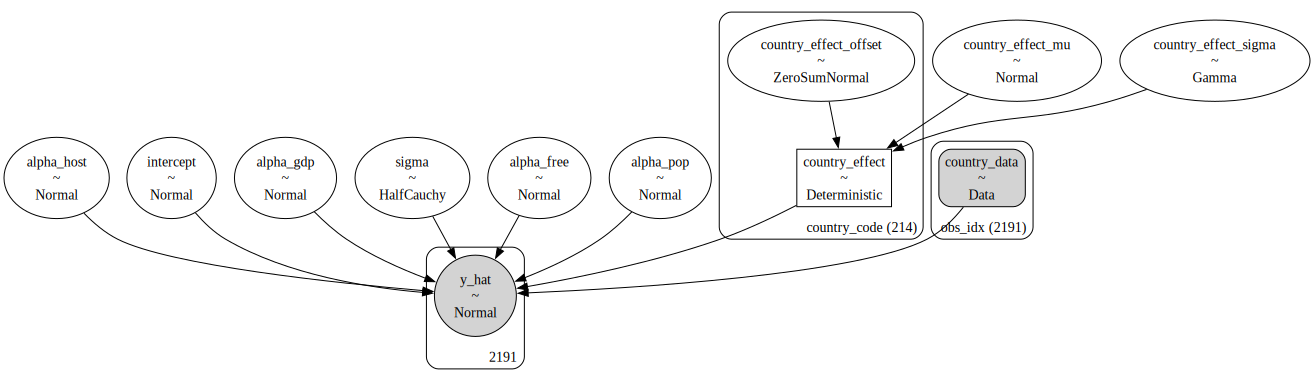

In [57]:
pm.model_to_graphviz(model)

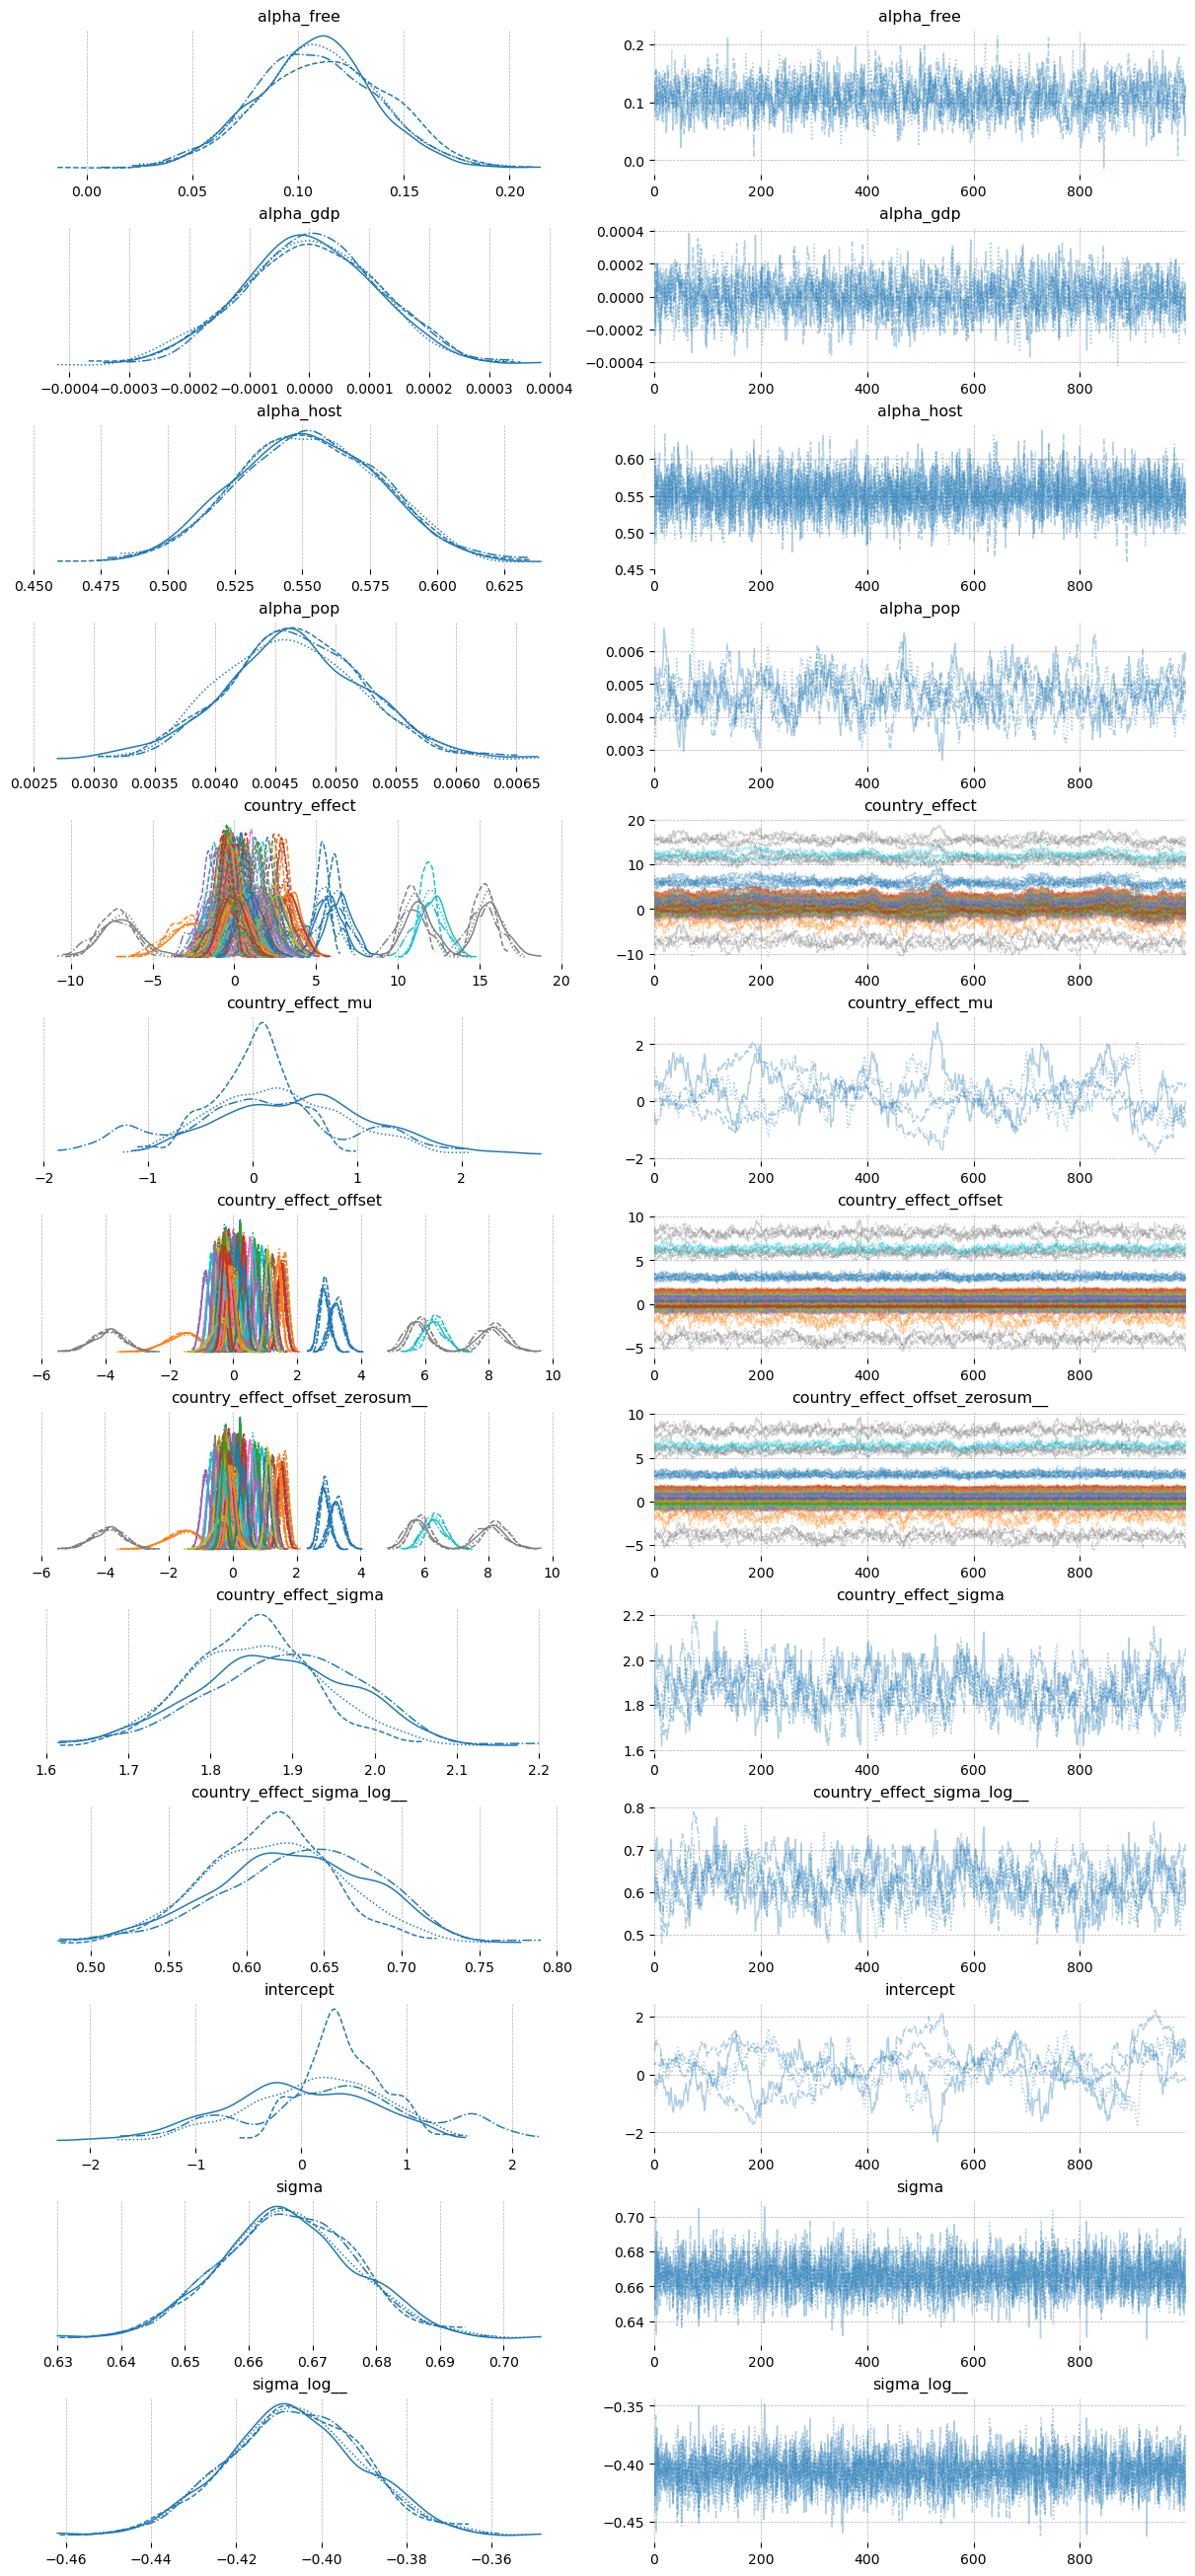

In [58]:
az.plot_trace(idata);

In [59]:
predictions = np.mean(idata.predictions['y_hat'], axis=(0, 1))

In [60]:
hdi_mean = az.hdi(idata.predictions.y_hat)

hdi = pd.DataFrame(hdi_mean['y_hat']).rename(columns={0:'low',1:'high'})

df_train['high'] = hdi['high']
df_train['low'] = hdi['low']

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_84690/4162940493.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['high'] = hdi['high']
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_84690/4162940493.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['low'] = hdi['low']


In [61]:
hdi_mean_50 = az.hdi(idata.predictions.y_hat, hdi_prob=.5)

hdi_50 = pd.DataFrame(hdi_mean_50['y_hat']).rename(columns={0:'low',1:'high'})

df_train['high_50'] = hdi_50['high']
df_train['low_50'] = hdi_50['low']

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_84690/752352581.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['high_50'] = hdi_50['high']
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_84690/752352581.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['low_50'] = hdi_50['low']


In [62]:
df_train['preds'] = predictions

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_84690/1527421163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['preds'] = predictions


In [63]:
df_train['error'] = (df_train['Total_pct'] - df_train['preds'])**2

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_84690/3709973698.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['error'] = (df_train['Total_pct'] - df_train['preds'])**2


<Axes: xlabel='Total_pct', ylabel='preds'>

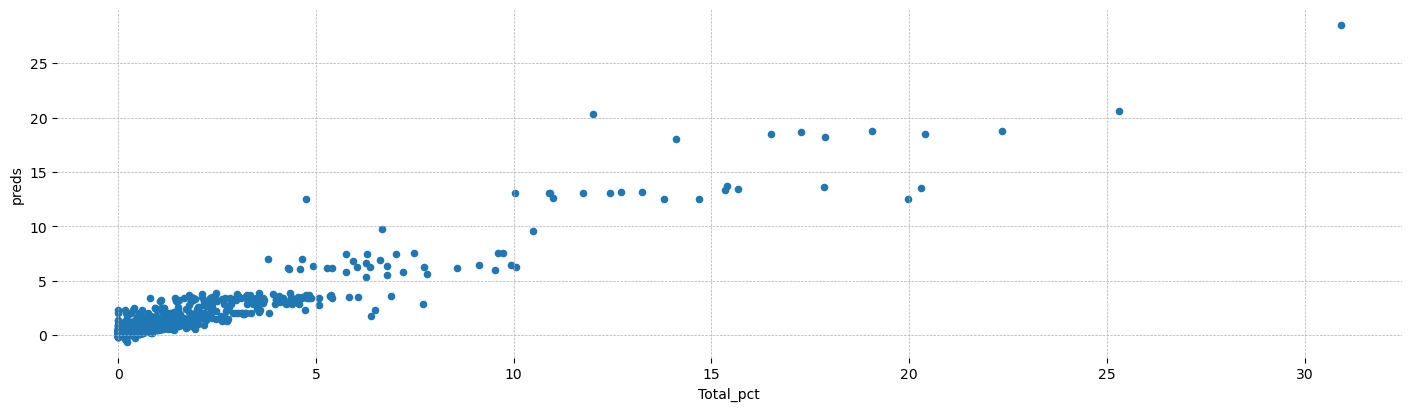

In [64]:
df_train.plot.scatter(x='Total_pct',y='preds')

In [65]:
df_train.loc[df['year']==2016].to_csv("test.csv")

In [66]:
df_train

,game_id,country_code,participant,host_country,year,Gold_pct,Silver_pct,Bronze_pct,Total_pct,gdp,...,free,gdp_norm,pop_norm,free_norm,high,low,high_50,low_50,preds,error
214,rio-2016,AD,1,0,2016,0.000000,0.000000,0.000000,0.000000,2.896610e+09,...,1.0,-0.198913,-0.261943,-1.310521,1.296792,-1.346588,0.460875,-0.490370,-0.062167,0.003865
216,rio-2016,AR,1,0,2016,0.977199,0.325733,0.000000,0.411100,5.575323e+11,...,2.0,0.130713,0.049090,-0.822541,2.136302,-0.433083,1.291271,0.351327,0.250440,0.025812
217,rio-2016,AT,1,0,2016,0.000000,0.000000,0.278552,0.102775,3.958374e+11,...,1.0,0.034616,-0.200018,-1.310521,1.461620,-1.118792,0.630572,-0.320673,0.311496,0.043565
218,rio-2016,AU,1,0,2016,2.605863,3.583062,2.785515,2.980473,1.207581e+12,...,1.0,0.517044,-0.089563,-1.310521,1.447450,-1.169768,0.626745,-0.315263,3.433526,0.205257
219,rio-2016,BE,1,0,2016,0.651466,0.651466,0.557103,0.616650,4.760628e+11,...,1.0,0.082295,-0.181473,-1.310521,2.209077,-0.373886,1.544843,0.628224,0.450284,0.027678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,rome-1960,VE,1,0,1960,0.000000,0.000000,0.625000,0.216920,7.663938e+09,...,2.0,-0.107603,-0.122612,-0.822541,NaN,NaN,NaN,NaN,0.057905,0.025286
3398,rome-1960,VN,1,0,1960,0.000000,0.000000,0.000000,0.000000,6.635334e+10,...,4.5,0.604822,0.298490,0.397411,NaN,NaN,NaN,NaN,-0.084164,0.007084
3408,rome-1960,SO,1,0,1960,0.000000,0.000000,0.000000,0.000000,1.804599e+08,...,6.5,-0.198444,-0.213243,1.373372,NaN,NaN,NaN,NaN,-0.019313,0.000373
3413,rome-1960,LR,1,0,1960,0.000000,0.000000,0.000000,0.000000,1.904956e+08,...,6.0,-0.198322,-0.242967,1.129381,NaN,NaN,NaN,NaN,0.062251,0.003875
